In [164]:
# Download Station data for ModMon

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylib import *
from datetime import datetime
import matplotlib.dates as mdates
from scipy.stats import skew
from matplotlib.offsetbox import AnchoredText
import folium
import calendar
from scipy.stats import norm
import seaborn as sns


##################################### Station Data Import ###########################################3

sta_names = ['ModMon']

file = ('/Users/kboothomefolder/phy577_projects/proj2/ModMon/NREWQ_9Nov2021.csv')
stas = pd.read_csv(file)
stas = pd.DataFrame(stas.iloc[:, :12])

# Columns in ModMon Dataset: 
# ['Date', 'Year', 'Season', 'Station', 'Source', 'Depth', 'YSI_Time', 'YSI_Depth', 'YSI_Temp', 'YSI_Salinity', 'YSI_Turbidity']

#print(stas.columns)

##################################### Create Dataframe ###########################################3

# Fix time inputs (some error)

stas['YSI_Time'].fillna('00:00', inplace=True)
stas.loc[stas['YSI_Time'].str.startswith('-'), 'YSI_Time'] = '00:00'

# Clean dataset and prep variables

stas['Time'] = pd.to_datetime(stas['Date'] + ' ' + stas['YSI_Time'])
stas['Sal'] = np.asarray(pd.to_numeric(stas['YSI_Salinity']))
stas['Temp'] = np.asarray(pd.to_numeric(stas['YSI_Temp']))
stas['S_Dep'] = np.asarray(stas['Depth'])
stas['Depth'] = np.asarray(pd.to_numeric(stas['YSI_Depth']))

#################################### Clean Stations List ################################################

# Filter Out Unspecific Stations (coords not available)
stations_to_filter = [
    'Streets Ferry Bridge',
    'Fisher Landing',
    'Camp Seafarer',
    'Union Point Neuse',
    'Union Point Trent',
    'Neuse River at Kinston'
]

# Filter out rows with specified station names
stas = stas[~stas['Station'].isin(stations_to_filter)]

# Assuming 'S' is your DataFrame
name_err = ['20', '30', '50', '60', '70', '100', '120', '140', '160', '180', '0']
stas['Station'] = stas['Station'].replace(name_err, [20, 30, 50, 60, 70, 100, 120, 140, 160, 180, 0])

stations = stas['Station'].unique()
#print(stations)

#################################### Create Dataframes ################################################

S = stas[['Time', 'Season', 'Station', 'S_Dep', 'Depth', 'Sal']]
T = stas[['Time', 'Season', 'Station', 'S_Dep', 'Depth', 'Temp']]

S.drop(S[S['Sal'] < 0].index, inplace=True)
S.dropna(subset = ['Sal'], inplace = True)

T.drop(T[T['Temp'] < -15].index, inplace=True)
T.dropna(subset = ['Temp'], inplace = True)

########################################## Sort by Station ########################################################

# Remove Statons 80 and 130 due to no data collected

stations = stas['Station'].unique()

print(stations) 

remove_sta = [80, 130] 

# selected stations based on NRE location (head at 0 to mouth at 180)
sta_select = [20, 100, 180]

# Create a dataframe for each selected station
#S_sta_20 = S[S['Station'] == 20]

# Create an empty dictionary to store the DataFrames
S_sta_20 = {}

S_sta_20['S'] = S[(S['Station'] == 20) & (S['S_Dep'] == 'S')]
S_sta_20['B'] = S[(S['Station'] == 20) & (S['S_Dep'] == 'B')]

S_sta_100 = {}

S_sta_100['S'] = S[(S['Station'] == 100) & (S['S_Dep'] == 'S')]
S_sta_100['B'] = S[(S['Station'] == 100) & (S['S_Dep'] == 'B')]

S_sta_180 = {}

S_sta_180['S'] = S[(S['Station'] == 180) & (S['S_Dep'] == 'S')]
S_sta_180['B'] = S[(S['Station'] == 180) & (S['S_Dep'] == 'B')]

#print(len(S_sta_20['S']))

/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_19645/1992984046.py:22: DtypeWarning: Columns (3,32,33,47,51,78,79,81,82,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  stas = pd.read_csv(file)
/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_19645/1992984046.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stas['Time'] = pd.to_datetime(stas['Date'] + ' ' + stas['YSI_Time'])


[  0  10  20  30  70 120  80  60  50 100 140 160 165  95  96 180 130]


/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_19645/1992984046.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S.drop(S[S['Sal'] < 0].index, inplace=True)
/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_19645/1992984046.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S.dropna(subset = ['Sal'], inplace = True)
/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_19645/1992984046.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

In [83]:
'''
# Iterate through unique stations and split the data
for station in stations:
    for station in sta_select:
        S_sta[station] = S[S['Station'] == station]
'''
#print(S_sta) 

# print(S_sta.items()) # items are sections of S_sta where each station's data is stored by station name as item title.

##################################### Divide into surface and bottom salinity #####################################

SS = {station: data[data['S_Dep'] == 'S'] for station, data in S_sta.items()}
BS = {station: data[data['S_Dep'] == 'B'] for station, data in S_sta.items()}

################################ Calculate Statistical Moments for each station using a function ##############################################
################################ Aggregate Salinity Stats for dataset  ##############################################

def compute_stats(dataset):
    stats_list = []
    for station, data in dataset.items():
        stat_values = {
            'mean': np.mean(data['Sal']),
            'std': np.std(data['Sal']),
            'skew': skew(data['Sal']),
            'var': np.var(data['Sal'])
        }
        stats_list.append(stat_values)
        print(f"Stat Calcs for Station {station}:")
        print(stat_values)
    return stats_list

# Compute statistics for different datasets
S_stats = compute_stats(S_sta)
SS_stats = compute_stats(SS)
BS_stats = compute_stats(BS)


################################ Monthly (Jan, Feb, etc.) Salinity Stats for each year ##############################################

def compute_mo_stats(dataset):
    month_stats_list = []
    for station, data in dataset.items():
        monthly_stats = data.groupby([data['Time'].dt.year, data['Time'].dt.month])['Sal'].agg(['mean', 'std', skew, 'var'])
        monthly_stats.index.names = ['Year', 'Month']
        month_stats_list.append({station: monthly_stats})
    return month_stats_list

# Compute statistics for each salinity dataset
S_stats_mo = compute_mo_stats(S_sta)
SS_stats_mo = compute_mo_stats(SS)
BS_stats_mo = compute_mo_stats(BS)

################################ Seasonal (Spring, Summer, Fall, Winter) Salinity Stats for each year ##############################################

def compute_seasonal_stats(dataset):
    seasonal_stats_list = []
    for station, data in dataset.items():
        # 'Season' is a column in the dataset labeled as 'Winter', 'Spring', 'Summer', 'Fall'
        
        seasonal_stats = data.groupby([data['Time'].dt.year, 'Season'])['Sal'].agg(['mean', 'std', skew, 'var'])
        seasonal_stats.index.names = ['Year', 'Season']
        seasonal_stats_list.append({station: seasonal_stats})
    return seasonal_stats_list

# Compute statistics for each salinity dataset based on season
S_stats_season = compute_seasonal_stats(S_sta)
SS_stats_season = compute_seasonal_stats(SS)
BS_stats_season = compute_seasonal_stats(BS)


def convert_to_dataframe(seasonal_stats_list):
    dfs = []
    for stats_dict in seasonal_stats_list:
        station, seasonal_stats = list(stats_dict.items())[0]
        df = pd.DataFrame(seasonal_stats)
        df.reset_index(inplace=True)
        df['Station'] = station  # Adding 'Station' column
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Convert seasonal statistics lists to Pandas DataFrames
S_stats_season_df = convert_to_dataframe(S_stats_season)
SS_stats_season_df = convert_to_dataframe(SS_stats_season)
BS_stats_season_df = convert_to_dataframe(BS_stats_season)

/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_19645/2585215710.py:21: DtypeWarning: Columns (3,32,33,47,51,78,79,81,82,85,86) have mixed types. Specify dtype option on import or set low_memory=False.
  stas = pd.read_csv(file)
/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_19645/2585215710.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stas['Time'] = pd.to_datetime(stas['Date'] + ' ' + stas['YSI_Time'])
/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_19645/2585215710.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  S.drop(S[S['Sal'] < 0].index, inplace=True)
/var/folders/x9/p_chwt0x52dgywjzc864nsd40000gn/T/ipykernel_196

Stat Calcs for Station 20:
{'mean': 1.2750161812297736, 'std': 3.042966809909477, 'skew': 3.040621255791662, 'var': 9.25964700621066}
Stat Calcs for Station 100:
{'mean': 9.820831826401447, 'std': 5.732309324708567, 'skew': 0.16520305938565857, 'var': 32.85937019414079}
Stat Calcs for Station 180:
{'mean': 16.10672278338945, 'std': 4.919959307283779, 'skew': -0.14833018870255013, 'var': 24.205999585328282}
Stat Calcs for Station 20:
{'mean': 0.43093851132686084, 'std': 0.9451982683255827, 'skew': 3.4896041889888463, 'var': 0.8933997664456803}
Stat Calcs for Station 100:
{'mean': 7.690361663652804, 'std': 5.009649770952864, 'skew': 0.4037639331401449, 'var': 25.096590827608082}
Stat Calcs for Station 180:
{'mean': 14.769774774774776, 'std': 4.782801013512812, 'skew': -0.11965730851403113, 'var': 22.875185534859188}
Stat Calcs for Station 20:
{'mean': 2.119093851132686, 'std': 4.025041617215676, 'skew': 1.9880661304863636, 'var': 16.20096002031818}
Stat Calcs for Station 100:
{'mean': 11

/opt/homebrew/lib/python3.8/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
/opt/homebrew/lib/python3.8/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
/opt/homebrew/lib/python3.8/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
/opt/homebrew/lib/python3.8/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment ca

25.0
155


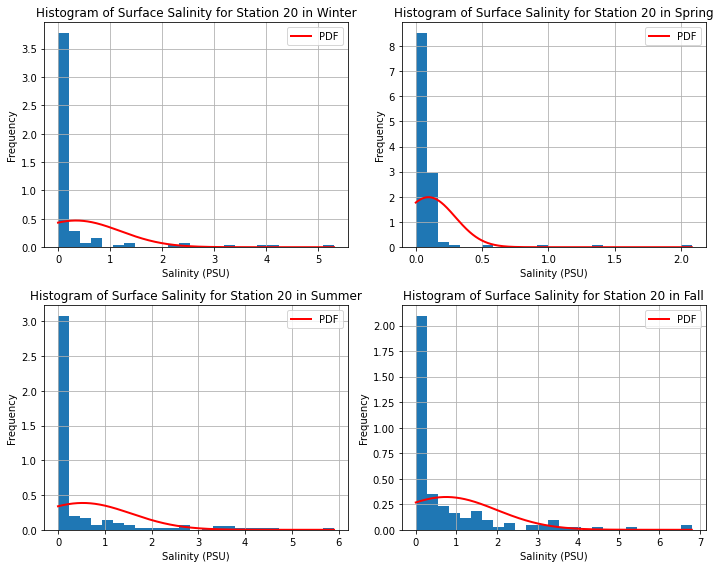

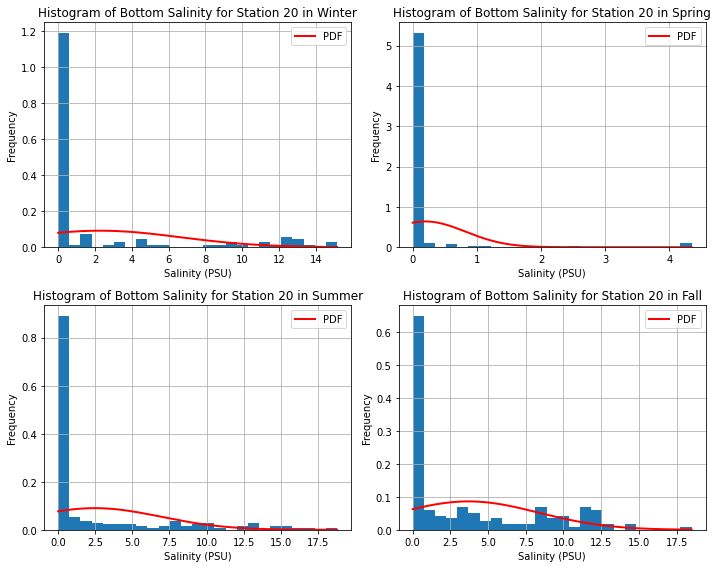

In [161]:
#################################### Station 20 ################################################

################################# Histogram ########################################################################
# Generate a sample bin-averaged probability distribution function for seasonal salinity mean at each station in S_stats_season

bins = round(np.sqrt((len(S_sta_20['B']))), 0)
print(bins)

std_dev = S_data['Sal'].std()
NS = len(S_sta_20['B'])
SSbins = round(3.5 * (std_dev / (NS ** (-1/3))))
print(SSbins)

import os

# Create subplots for each season
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # Flatten the array for easy iteration

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i, season in enumerate(seasons):
    S_data = S_sta_20['S'][S_sta_20['S']['Season'] == season]
    min_val = S_data['Sal'].min()
    max_val = S_data['Sal'].max()

    sample_mean = S_data['Sal'].mean()
    std_dev = S_data['Sal'].std()

    # Generate x-values for the estimated normal distribution
    x_val = np.linspace(min_val, max_val, 1000)

    # Create the estimated normal distribution
    pdf_est = norm.pdf(x_val, loc=sample_mean, scale=std_dev)

    # Plot on respective subplot
    axs[i].hist(S_data['Sal'], bins=25, range=(min_val, max_val), density=True)
    axs[i].plot(x_val, pdf_est, linewidth=2, color='red', label='PDF')
    axs[i].set_title(f'Histogram of Surface Salinity for Station 20 in {season}')
    axs[i].set_xlabel('Salinity (PSU)')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Hist_S20.png'))


# Create subplots for each season
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # Flatten the array for easy iteration

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i, season in enumerate(seasons):
    B_data = S_sta_20['B'][S_sta_20['B']['Season'] == season]
    min_val = B_data['Sal'].min()
    max_val = B_data['Sal'].max()

    sample_mean = B_data['Sal'].mean()
    std_dev = B_data['Sal'].std()

    # Generate x-values for the estimated normal distribution
    x_val = np.linspace(min_val, max_val, 1000)

    # Create the estimated normal distribution
    pdf_est = norm.pdf(x_val, loc=sample_mean, scale=std_dev)

    # Plot on respective subplot
    axs[i].hist(B_data['Sal'], bins=25, range=(min_val, max_val), density=True)
    axs[i].plot(x_val, pdf_est, linewidth=2, color='red', label='PDF')
    axs[i].set_title(f'Histogram of Bottom Salinity for Station 20 in {season}')
    axs[i].set_xlabel('Salinity (PSU)')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Hist_B20.png'))



24.0
144


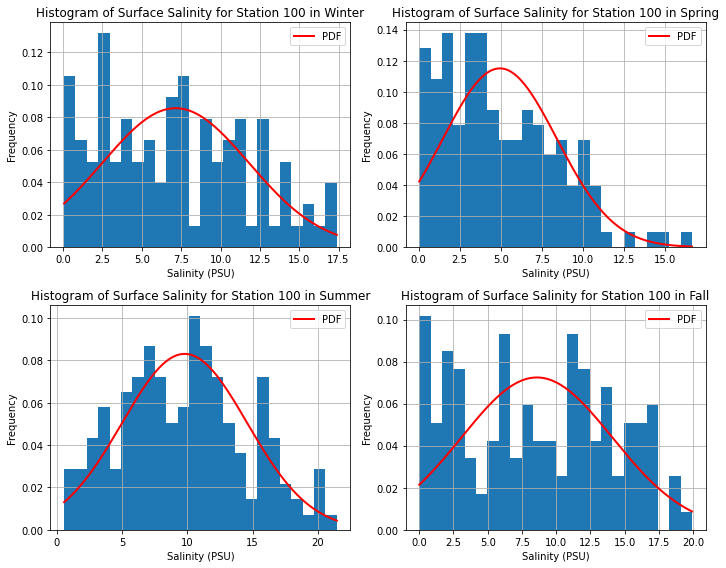

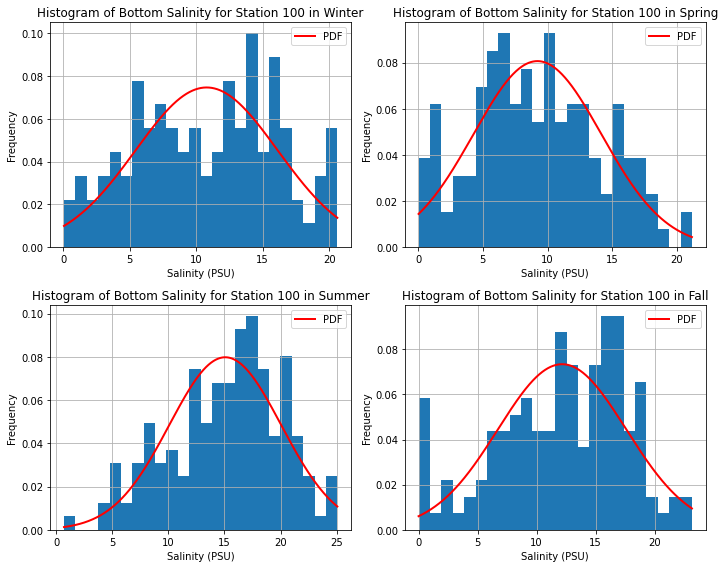

In [162]:
#################################### Station 100 ################################################

################################# Histogram ########################################################################
# Generate a sample bin-averaged probability distribution function for seasonal salinity mean at each station in S_stats_season



bins = round(np.sqrt((len(S_sta_100['S']))), 0)
print(bins)

std_dev = S_sta_100['S']['Sal'].std()
NS = len(S_sta_100['S'])
SSbins = round(3.5 * (std_dev / (NS ** (-1/3))))
print(SSbins)


# Create subplots for each season
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # Flatten the array for easy iteration

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i, season in enumerate(seasons):
    S_data = S_sta_100['S'][S_sta_100['S']['Season'] == season]
    min_val = S_data['Sal'].min()
    max_val = S_data['Sal'].max()

    sample_mean = S_data['Sal'].mean()
    std_dev = S_data['Sal'].std()

    # Generate x-values for the estimated normal distribution
    x_val = np.linspace(min_val, max_val, 1000)

    # Create the estimated normal distribution
    pdf_est = norm.pdf(x_val, loc=sample_mean, scale=std_dev)

    # Plot on respective subplot
    axs[i].hist(S_data['Sal'], bins=24, range=(min_val, max_val), density=True)
    axs[i].plot(x_val, pdf_est, linewidth=2, color='red', label='PDF')
    axs[i].set_title(f'Histogram of Surface Salinity for Station 100 in {season}')
    axs[i].set_xlabel('Salinity (PSU)')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Hist_S100.png'))


# Create subplots for each season
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # Flatten the array for easy iteration

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i, season in enumerate(seasons):
    B_data = S_sta_100['B'][S_sta_100['B']['Season'] == season]
    min_val = B_data['Sal'].min()
    max_val = B_data['Sal'].max()

    sample_mean = B_data['Sal'].mean()
    std_dev = B_data['Sal'].std()

    # Generate x-values for the estimated normal distribution
    x_val = np.linspace(min_val, max_val, 1000)

    # Create the estimated normal distribution
    pdf_est = norm.pdf(x_val, loc=sample_mean, scale=std_dev)

    # Plot on respective subplot
    axs[i].hist(B_data['Sal'], bins=24, range=(min_val, max_val), density=True)
    axs[i].plot(x_val, pdf_est, linewidth=2, color='red', label='PDF')
    axs[i].set_title(f'Histogram of Bottom Salinity for Station 100 in {season}')
    axs[i].set_xlabel('Salinity (PSU)')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Hist_B100.png'))



21.0
128


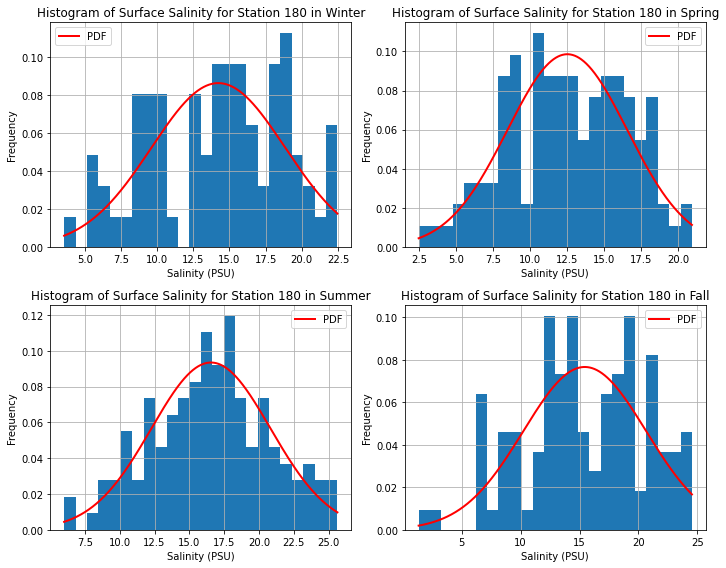

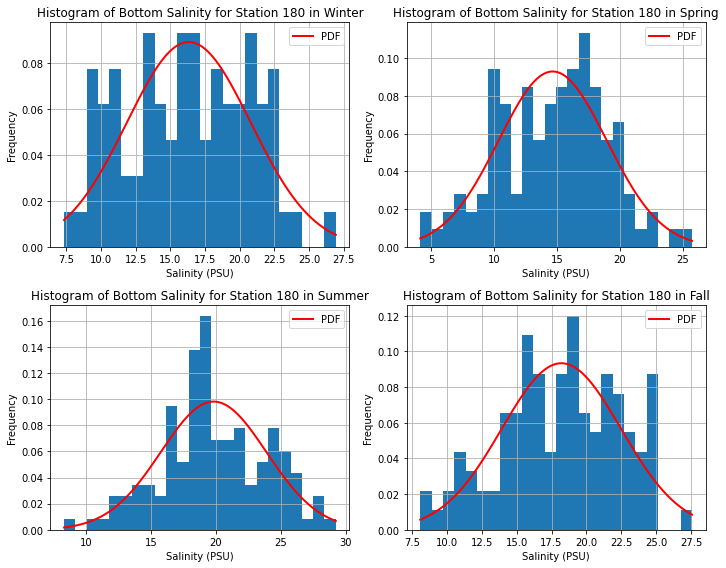

In [160]:
#################################### Station 180 ################################################

################################# Histogram ########################################################################
# Generate a sample bin-averaged probability distribution function for seasonal salinity mean at each station in S_stats_season

bins = round(np.sqrt((len(S_sta_180['S']))), 0)
print(bins)

std_dev = S_sta_180['S']['Sal'].std()
NS = len(S_sta_180['S'])
SSbins = round(3.5 * (std_dev / (NS ** (-1/3))))
print(SSbins)


# Create subplots for each season
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # Flatten the array for easy iteration

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i, season in enumerate(seasons):
    S_data = S_sta_180['S'][S_sta_180['S']['Season'] == season]
    min_val = S_data['Sal'].min()
    max_val = S_data['Sal'].max()

    sample_mean = S_data['Sal'].mean()
    std_dev = S_data['Sal'].std()

    # Generate x-values for the estimated normal distribution
    x_val = np.linspace(min_val, max_val, 1000)

    # Create the estimated normal distribution
    pdf_est = norm.pdf(x_val, loc=sample_mean, scale=std_dev)

    # Plot on respective subplot
    axs[i].hist(S_data['Sal'], bins=24, range=(min_val, max_val), density=True)
    axs[i].plot(x_val, pdf_est, linewidth=2, color='red', label='PDF')
    axs[i].set_title(f'Histogram of Surface Salinity for Station 180 in {season}')
    axs[i].set_xlabel('Salinity (PSU)')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Hist_S180.png'))


# Create subplots for each season
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.ravel()  # Flatten the array for easy iteration

seasons = ['Winter', 'Spring', 'Summer', 'Fall']
for i, season in enumerate(seasons):
    B_data = S_sta_180['B'][S_sta_180['B']['Season'] == season]
    min_val = B_data['Sal'].min()
    max_val = B_data['Sal'].max()

    sample_mean = B_data['Sal'].mean()
    std_dev = B_data['Sal'].std()

    # Generate x-values for the estimated normal distribution
    x_val = np.linspace(min_val, max_val, 1000)

    # Create the estimated normal distribution
    pdf_est = norm.pdf(x_val, loc=sample_mean, scale=std_dev)

    # Plot on respective subplot
    axs[i].hist(B_data['Sal'], bins=24, range=(min_val, max_val), density=True)
    axs[i].plot(x_val, pdf_est, linewidth=2, color='red', label='PDF')
    axs[i].set_title(f'Histogram of Bottom Salinity for Station 180 in {season}')
    axs[i].set_xlabel('Salinity (PSU)')
    axs[i].set_ylabel('Frequency')
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Hist_B180.png'))



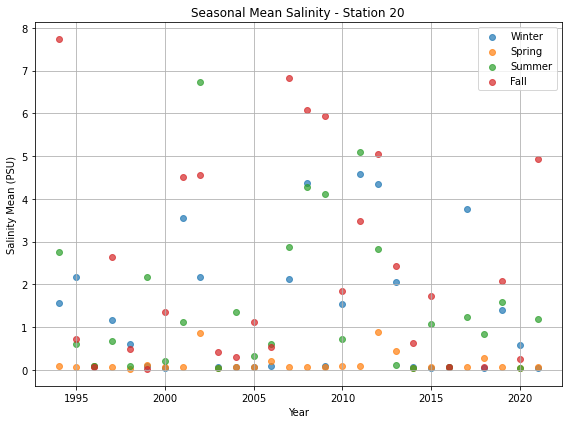

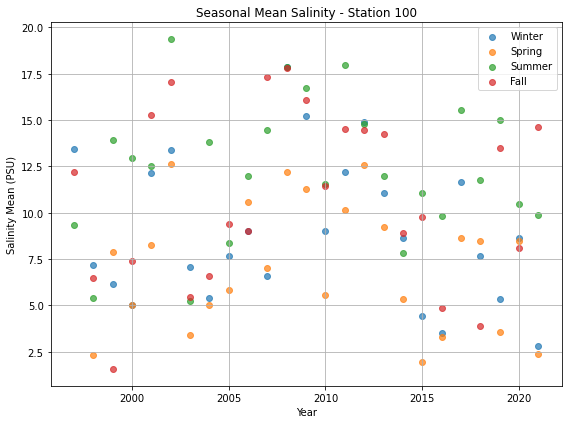

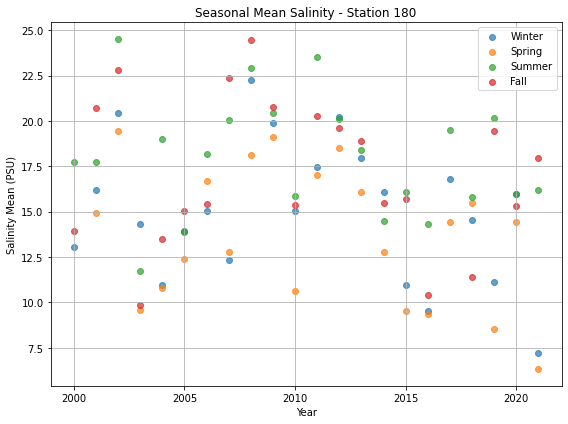

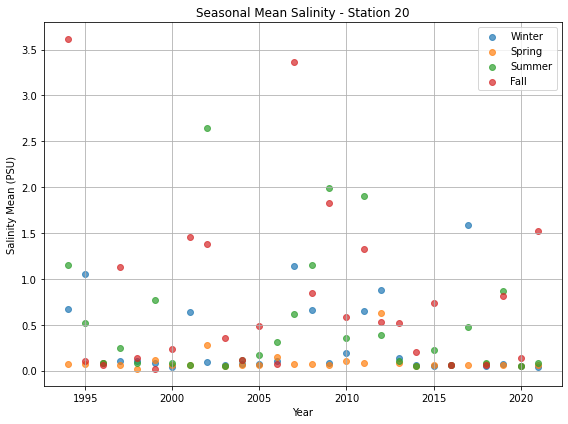

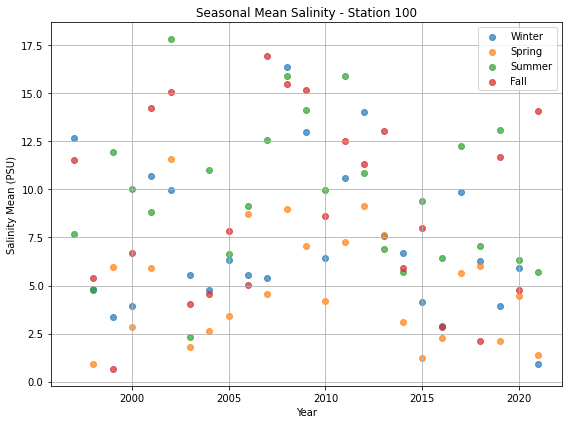

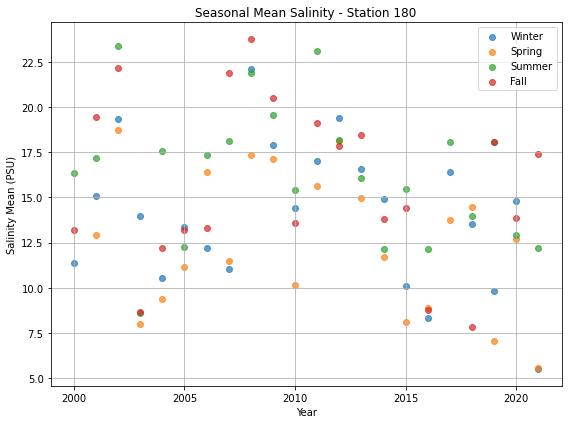

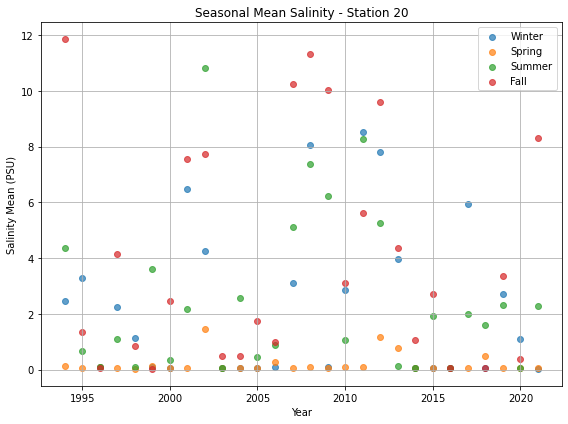

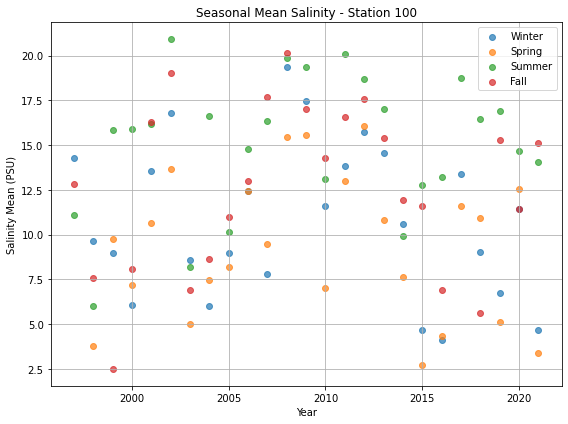

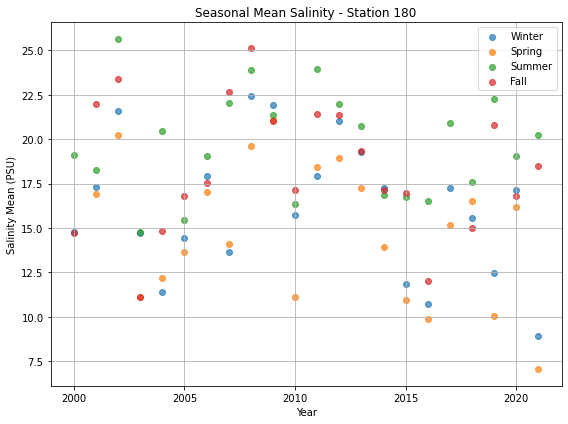

In [126]:
import matplotlib.pyplot as plt

def plot_seasonal_mean(stats_list):
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']

    for stat in stats_list:
        station = list(stat.keys())[0]  # Retrieve station name
        data = list(stat.values())[0]

        fig, axs = plt.subplots(figsize=(8, 6))

        for season in seasons:
            seasonal_mean = data.loc[data.index.get_level_values('Season') == season, 'mean']
            if not seasonal_mean.empty:
                years = seasonal_mean.index.get_level_values('Year')
                salinity_means = seasonal_mean.values

                axs.scatter(years, salinity_means, marker='o', label=season, alpha=0.7)

        axs.set_title(f'Seasonal Mean Salinity - Station {station}')
        axs.set_xlabel('Year')
        axs.set_ylabel('Salinity Mean (PSU)')
        axs.legend()
        axs.grid(True)

        plt.tight_layout()
        plt.show()

# Example usage
plot_seasonal_mean(S_stats_season)
plot_seasonal_mean(SS_stats_season)
plot_seasonal_mean(BS_stats_season)



In [74]:
################################# Function to Plot Monthly Mean Sal Data #####################################

import matplotlib.pyplot as plt

def plot_monthly_salinity(stats_list, month_number):
    month_data = []
    
    for stat in stats_list:
        for station, data in stat.items():
            monthly_mean = data.loc[(data.index.get_level_values('Month') == month_number), 'mean']
            month_data.append((station, monthly_mean))
    
    plt.figure(figsize=(10, 6))
    for station, monthly_mean in month_data:
        plt.scatter(monthly_mean.index.get_level_values('Year').values, monthly_mean.values, label=f'Station {station}')
    
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    month_name = months[month_number - 1]
    
    plt.title(f'Mean Salinity for {month_name} Across Observed Period')
    plt.xlabel('Year')
    plt.ylabel('Salinity Mean (PSU)')
    plt.legend()
    plt.grid(True)
    plt.show()
    

# Example usage for January (month number 1)
plot_monthly_salinity(S_stats_mo, 1)  # Change S_stats_mo to the desired variable and specify the month number
plot_monthly_salinity(SS_stats_mo, 1)
plot_monthly_salinity(BS_stats_mo, 1)

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Sta_Mo.png'))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_monthly_mean_distribution(stats_list, month_number):
    month_data = []

    for stat in stats_list:
        for station, data in stat.items():
            monthly_mean = data.loc[(data.index.get_level_values('Month') == month_number), 'mean']
            month_data.extend(monthly_mean.values)

    plt.figure(figsize=(10, 6))

    # Histogram plot
    plt.subplot(1, 2, 1)
    sns.histplot(month_data, bins=20, kde=False)
    plt.title('Monthly Mean Salinity Distribution (Histogram)')
    plt.xlabel('Salinity Mean (PSU)')
    plt.ylabel('Frequency')

    # PDF plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(month_data, bw_adjust=0.5)
    plt.title('Monthly Mean Salinity Distribution (PDF)')
    plt.xlabel('Salinity Mean (PSU)')
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()

# Example usage for January (month number 1)
plot_monthly_mean_distribution(S_stats_mo, 1)  # Change S_stats_mo to the desired variable and specify the month number


In [38]:
################################ Calculate Stats - Monthly and Annual ##############################################

S_stats_mo = []
S_stats_yr = []

def compute_stats_MY(dataset, data_type):
    for station, data in dataset.items():
        monthly_stats = data.groupby(data['Time'].dt.month)['Sal'].agg(['mean', 'std', 'skew', 'var'])
        monthly_stats.index.name = 'Month'
        S_stats_mo.append({station: monthly_stats})
    
        yr_stats = data.groupby(data['Time'].dt.year)['Sal'].agg(['mean', 'std', 'skew', 'var'])
        yr_stats.index.name = 'Year'
        {dataset}_stats_yr.append({station: yr_stats})

        print("Monthly Stat Calcs for Station:", station)
        print(monthly_stats)
    
        print("Annual Stat Calcs for Station:", station)
        print(yr_stats)

compute_stats_MY(S_sta, 'All Obs')
compute_stats_MY(SS, 'Surface')
compute_stats_MY(BS, 'Bottom')

'''
######## Create a function to calculate and plot monthly and yearly statistics for all three datasets

def plot_stats(data_stats, data_type):
    for i, stat in enumerate(dataset):
        station, stats = stat.items()[0]
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        
        axs[0].plot(stats.index, stats['mean'], label='Mean')
        axs[0].plot(stats.index, stats['std'], label='Std')
        axs[0].set_title(f'Station {station} {data_type} Monthly Statistics')
        axs[0].set_xlabel('Time')
        axs[0].set_ylabel('Values')
        axs[0].legend()
        axs[0].grid(True)
        
        axs[1].plot(stats.index, stats['skew'], label='Skewness')
        axs[1].plot(stats.index, stats['var'], label='Variance')
        axs[1].set_title(f'Station {station} {data_type} Yearly Statistics')
        axs[1].set_xlabel('Time')
        axs[1].set_ylabel('Values')
        axs[1].legend()
        axs[1].grid(True)
        
        plt.tight_layout()
        #plt.savefig(os.path.join(output_dir, f'NRE_{data_type}_Stats_Station_{station}.png'))

# Plotting statistics for S_sta
plot_stats(S_sta, 'All Obs')
plot_stats(SS, 'Surface')
plot_stats(BS, 'Bottom')

    
'''


Monthly Stat Calcs for Station: 20
           mean       std      skew        var
Month                                         
1      0.949143  2.764027  3.579914   7.639843
2      0.320488  1.451540  7.396318   2.106968
3      0.134474  0.464417  7.477174   0.215683
4      0.085364  0.105619  6.221470   0.011155
5      0.215000  0.636554  5.260011   0.405201
6      0.571786  1.586987  3.812738   2.518527
7      1.197105  3.064481  3.443124   9.391046
8      2.615000  4.329681  1.971586  18.746137
9      1.971917  3.289641  1.916443  10.821740
10     2.568559  4.039935  1.781775  16.321076
11     2.280119  3.757966  1.841131  14.122310
12     2.527353  4.525773  1.774421  20.482623
Annual Stat Calcs for Station: 20
          mean       std      skew        var
Year                                         
1994  3.177273  5.014067  1.805029  25.140867
1995  0.730769  2.038506  4.657806   4.155505
1996  0.078846  0.041238 -1.454956   0.001701
1997  1.051923  2.257318  3.023606   5.0954

"\n######## Create a function to calculate and plot monthly and yearly statistics for all three datasets\n\ndef plot_stats(data_stats, data_type):\n    for i, stat in enumerate(dataset):\n        station, stats = stat.items()[0]\n        fig, axs = plt.subplots(2, 1, figsize=(10, 10))\n        \n        axs[0].plot(stats.index, stats['mean'], label='Mean')\n        axs[0].plot(stats.index, stats['std'], label='Std')\n        axs[0].set_title(f'Station {station} {data_type} Monthly Statistics')\n        axs[0].set_xlabel('Time')\n        axs[0].set_ylabel('Values')\n        axs[0].legend()\n        axs[0].grid(True)\n        \n        axs[1].plot(stats.index, stats['skew'], label='Skewness')\n        axs[1].plot(stats.index, stats['var'], label='Variance')\n        axs[1].set_title(f'Station {station} {data_type} Yearly Statistics')\n        axs[1].set_xlabel('Time')\n        axs[1].set_ylabel('Values')\n        axs[1].legend()\n        axs[1].grid(True)\n        \n        plt.tight_lay

In [ ]:
################################ Figure for Monthly & Annual  Statistical Moments ##############################################

fig, axs = plt.subplots(len(S_stats_mo), figsize=(10, 6 * len(S_stats_mo)))

for i, stats in enumerate(S_stats_mo):
    station = list(stats.keys())[0]
    monthly_means = stats[station]['mean']
    mo_names = [calendar.month_name[month] for month in monthly_means.index]

    axs[i].scatter(mo_names, monthly_means.values)
    axs[i].set_title(f'Station {station} Monthly Mean Salinity')
    axs[i].set_xlabel('Month')
    axs[i].set_ylabel('Mean Salinity (PSU)')
    axs[i].tick_params(axis='x', rotation=315)
    axs[i].grid(True)
    
plt.tight_layout()
plt.show()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Sta_Mo.png'))

################################ Figure for Annual Statistical Moments ##############################################

fig, axs = plt.subplots(len(S_stats_yr), figsize=(10, 6 * len(S_stats_yr)))

for i, stats in enumerate(S_stats_yr):
    station = list(stats.keys())[0]
    annual_means = stats[station]['mean']

    axs[i].scatter(annual_means.index, annual_means.values)
    axs[i].set_title(f'Station {station} Annual Mean Salinity')
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Mean Salinity (PSU)')
    axs[i].tick_params(axis='x', rotation=315)
    axs[i].grid(True)
    
plt.tight_layout()
plt.show()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Sta_Yr.png'))

In [ ]:
############################## Histogram ###########################################################

sta_100 = S_sta[100]

# Group into surface salinity, mid salinity, and deep salinity

SS_100 = sta_100[sta_100['S_Dep'] == 'S']
BS_100 = sta_100[sta_100['S_Dep'] == 'B']


############################## Surface Salinity Histogram ##################3
'''
sal_range = (min(SS_100['Sal']), max(SS_100['Sal']))
num_bins = 20 ## estimate later

S_hist, S_bin_edges = np.histogram(SSal['SURF_SAL_PSU'], bins=num_bins, range=sal_range, density=True)





############################### Estimated Normal Distribution ##################
# Generate x-values for the estimated normal distribution


S_x_val = np.linspace(sal_range[0], sal_range[1], 1000) 
S_pdf_est = norm.pdf(S_x_val, loc=SS_mean, scale=SS_SD)

############################### Plot the PDF ###############################
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax1.set_ylabel('Probability Distribution')
ax2.bar(S_bin_cent, S_hist, width=(S_bin_cent[1] - S_bin_cent[0]), align='center ax2.plot(S_x_val, S_pdf_est, color='red', label='Estimated Normal Distribution') ax2.set_xlabel('Salinity (PSU)')
ax2.set_ylabel('Probability Distribution')
plt.suptitle('Surface Temperature and Salinity PDF') ax1.grid(True)

savefig(os.path.join(output_dir, 'LJ_PDF_Hist.png')) bin_width_temp = (temp_range[1] - temp_range[0]) / num_bins
bin_width_salinity = (sal_range[1] - sal_range[0]) / num_bins

print(f"Salinity bin width: {round(bin_width_salinity,2)} (PSU)")
'''        

'''
# Group salinity data by month for station 100
mo_sal = sta_100.groupby(sta_100['Time'].dt.month)['Sal']

# Create a histogram for each month
fig, axs = plt.subplots(len(mo_sal), figsize=(8, 6 * len(mo_sal)))

for i, (month, salinity_data) in enumerate(mo_sal):
    axs[i].hist(salinity_data, bins=20, density=True)
    month_name = calendar.month_name[month]

    axs[i].set_title(f'Station 100 Salinity - {month_name}')
    axs[i].set_xlabel('Salinity (PSU)')
    axs[i].set_ylabel('Probability Density')
    axs[i].grid(True)

plt.tight_layout()
plt.show()
'''

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

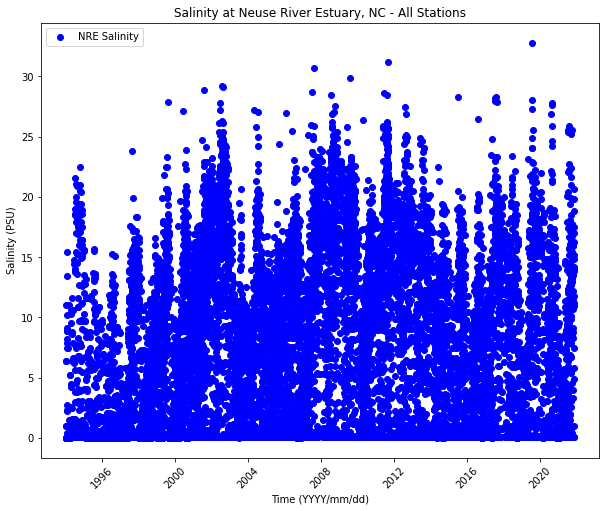

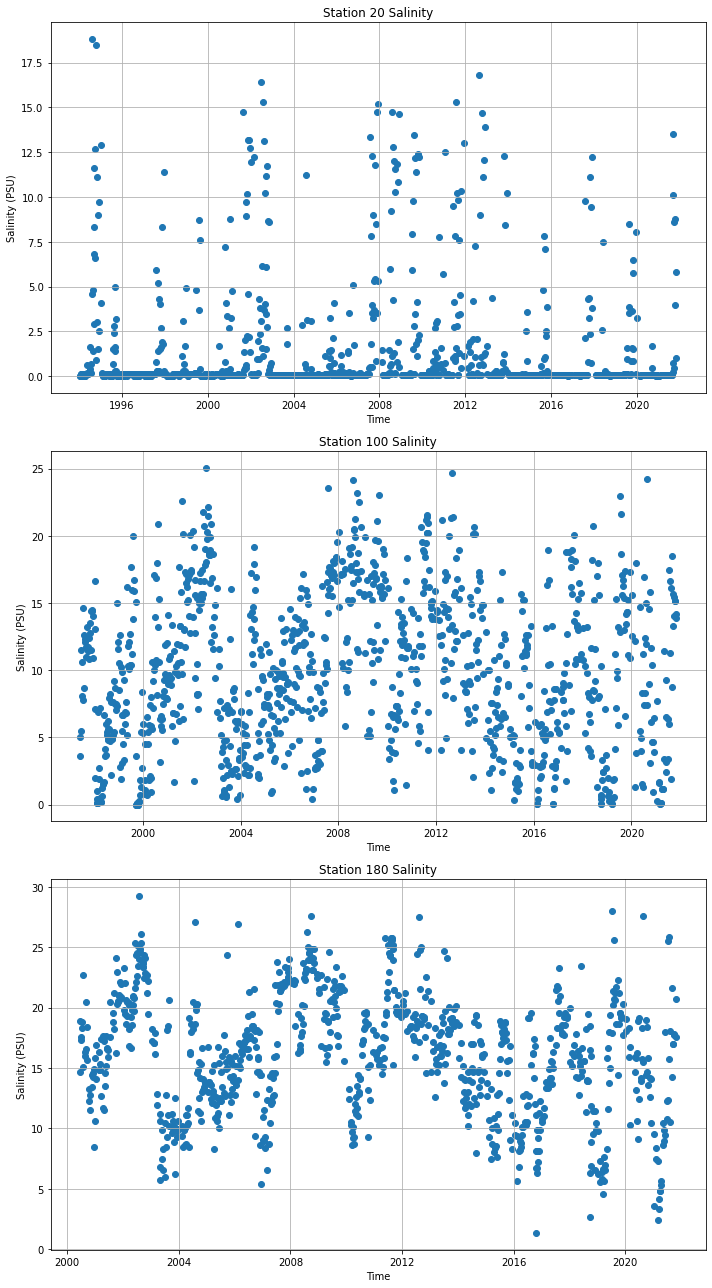

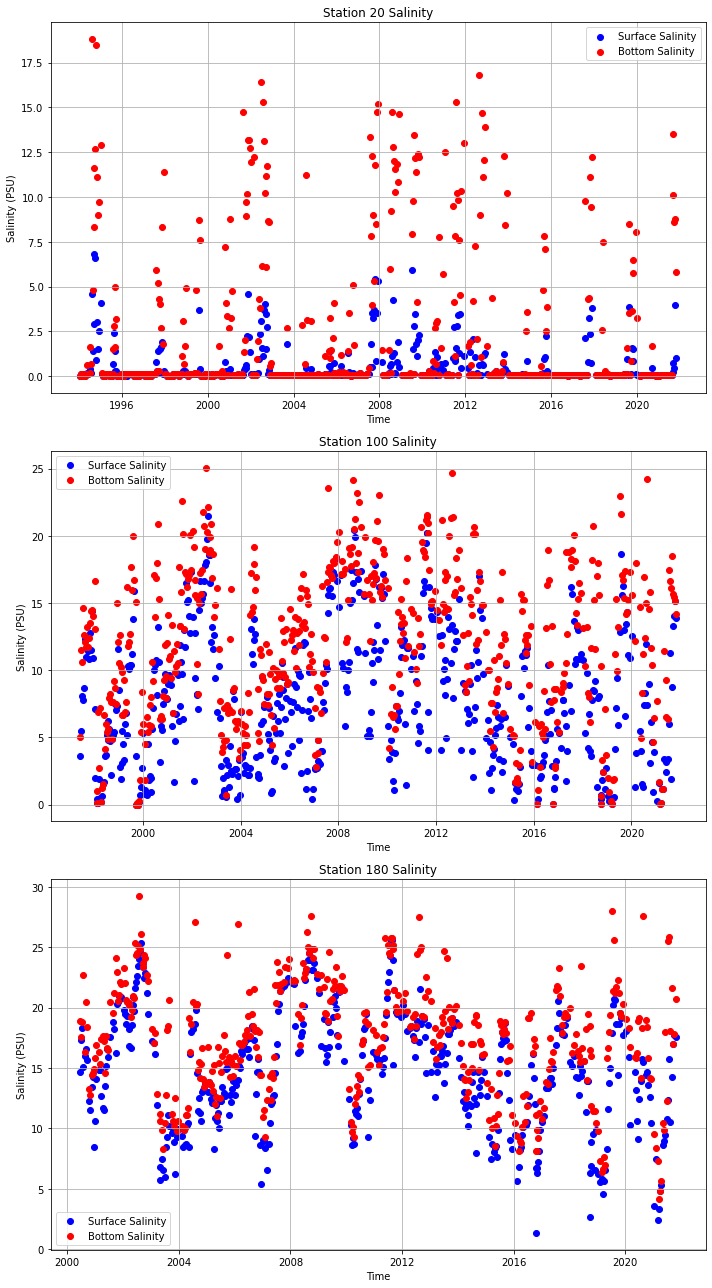

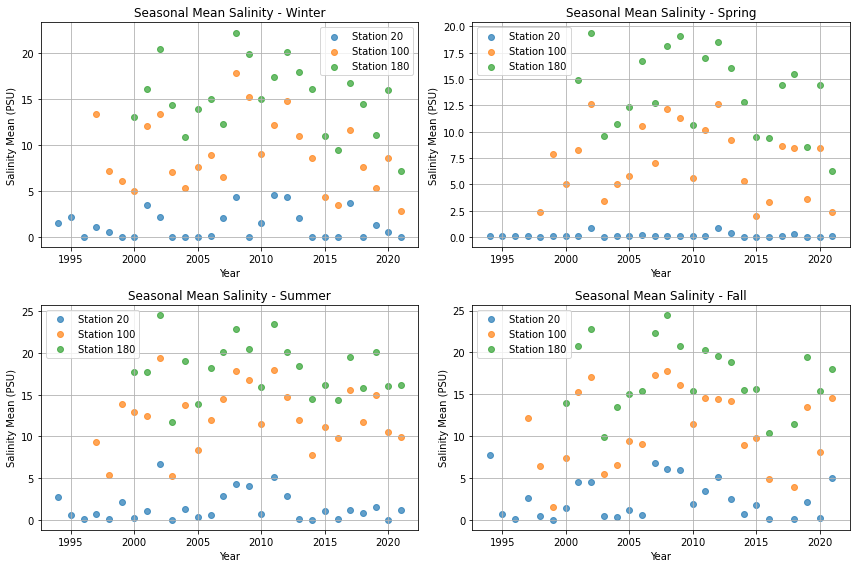

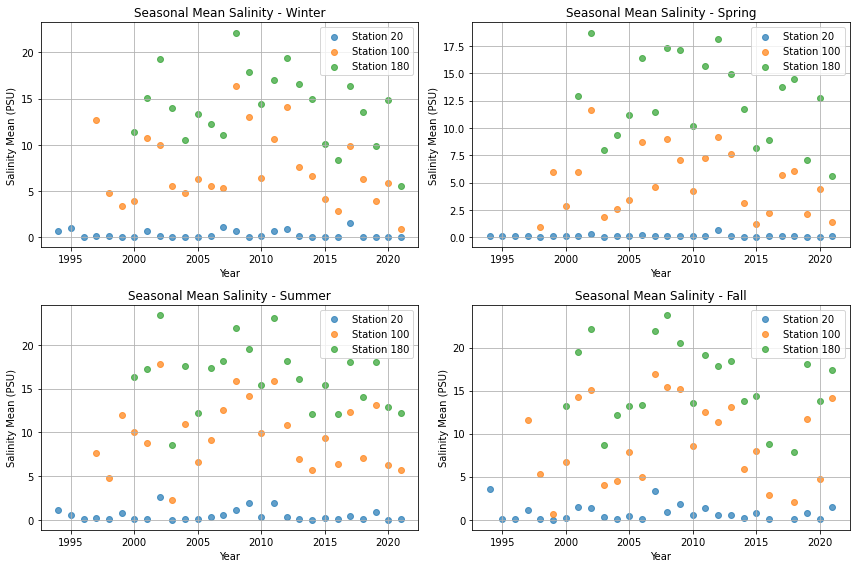

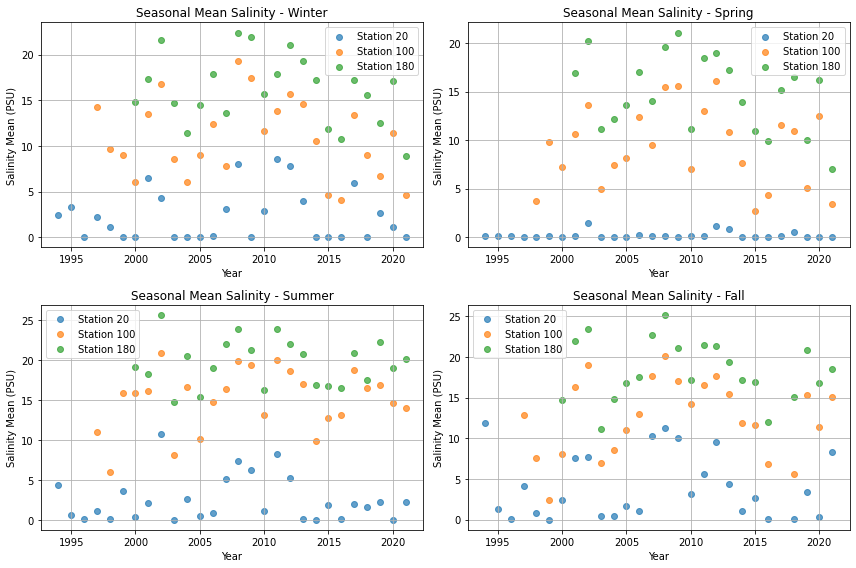

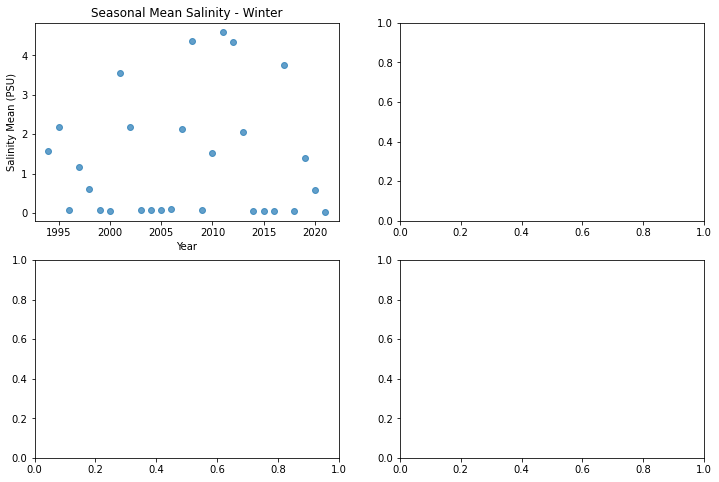

In [163]:
################################################ Final Data Plots ####################################################
###############################################################################################################

################################ Temperature and Salinity Time-Series - All Stations ####################################################

plt.figure(figsize=(10, 8))
plt.scatter(S['Time'].values, S['Sal'].values, color='blue', label='NRE Salinity')
plt.xlabel('Time (YYYY/mm/dd)')
plt.ylabel('Salinity (PSU)')
plt.xticks(rotation=45)
plt.legend()
plt.title('Salinity at Neuse River Estuary, NC - All Stations')

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_AllSta.png'))

'''
plt.figure(figsize=(10, 8))
plt.scatter(T['Time'].values, T['Temp'].values, color='red', label='NRE Temperature')
plt.xlabel('Time (YYYY/mm/dd)')
plt.ylabel('Temperature (C)')
plt.xticks(rotation=45)
plt.legend()
plt.title('Temperature at Neuse River Estuary, NC')

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Temp.png'))
'''

################################ Individual Station Timeseries -- Salinity ####################################################

fig, axs = plt.subplots(len(S_sta), figsize=(10, 6 * len(S_sta)))

for i, (station, data) in enumerate(S_sta.items()):
    axs[i].scatter(data['Time'].values, data['Sal'].values)
    axs[i].set_title(f'Station {station} Salinity')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Salinity (PSU)')
    axs[i].grid(True)
    plt.tight_layout()

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_StationsIndiv.png'))

################################ Individual Station Timeseries -- Surface and Bottom Salinity ####################################################

# Filter data for surface and bottom salinity

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'

fig, axs = plt.subplots(len(SS), 1, figsize=(10, 6 * len(SS)))

for i, (station, data) in enumerate(SS.items()):
    bs_data = BS[station]  # Get corresponding BS data for this station
    
    axs[i].scatter(data['Time'].values, data['Sal'].values, label='Surface Salinity', c='blue')
    axs[i].scatter(bs_data['Time'].values, bs_data['Sal'].values, label='Bottom Salinity', c='red')
    axs[i].set_title(f'Station {station} Salinity')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Salinity (PSU)')
    axs[i].grid(True)
    axs[i].legend()
    plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'NRE_Sal_SandB_Stations.png'))


############################## Seasonal Mean Salinity Time Series for each station ########################################################

import matplotlib.pyplot as plt

def plot_seasonal_distribution(stats_list):
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for i, season in enumerate(seasons):
        ax = axs[i]
        ax.set_title(f'Seasonal Mean Salinity - {season}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Salinity Mean (PSU)')

        for stat in stats_list:
            for station, data in stat.items():
                seasonal_mean = data.loc[data.index.get_level_values('Season') == season, 'mean']
                if not seasonal_mean.empty:
                    years = seasonal_mean.index.get_level_values('Year')
                    salinity_means = seasonal_mean.values

                    ax.scatter(years, salinity_means, marker='o', label=f'Station {station}', alpha=0.7)

        ax.legend()
        ax.grid(True)

    plt.tight_layout()


# Example usage for a particular season
plot_seasonal_distribution(S_stats_season)
output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal.png'))

plot_seasonal_distribution(SS_stats_season)
output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Surface.png'))

plot_seasonal_distribution(BS_stats_season)
output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Bottom.png'))


################################ Seasonal Linear Regression ####################################################

import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_seasonal_dist_reg(stats_list):
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.flatten()

    for i, season in enumerate(seasons):
        ax = axs[i]
        ax.set_title(f'Seasonal Mean Salinity - {season}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Salinity Mean (PSU)')

        for stat in stats_list:
            for station, data in stat.items():
                seasonal_mean = data.loc[data.index.get_level_values('Season') == season, 'mean']
                if not seasonal_mean.empty:
                    years = seasonal_mean.index.get_level_values('Year')
                    salinity_means = seasonal_mean.values

                    ax.scatter(years, salinity_means, marker='o', label=f'Station {station}', alpha=0.7)
                    
                    # Perform linear regression
                    slope, intercept, r_value, p_value, std_err = linregress(years, salinity_means)
                    regression_line = slope * years + intercept
                    
                    ax.plot(years, regression_line, color='red', label='Linear Regression', linewidth=2)
                    
        ax.legend()
        ax.grid(True)

    plt.tight_layout()

# Example usage for a particular season
plot_seasonal_dist_reg(S_stats_season)
output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_Reg.png'))

plot_seasonal_dist_reg(SS_stats_season)
output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_SurfaceReg.png'))

plot_seasonal_dist_reg(BS_stats_season)
output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
plt.savefig(os.path.join(output_dir, 'NRE_Sal_Seasonal_BottomReg.png'))

################################ Prob Dens Function (PDF) -- Seasonal Surface and Bottom Salinity ####################################################


In [7]:
# print(mod[0])

##################################### Station Info ##################################################3

# coordinates of PS stations (nre10 to nre180)

lon_nre = [-77.12220, -77.0904, -77.0765, -77.0353, -77.0317, -77.0064, -76.9693, -76.9594, -76.9442, -76.9215, -76.8755, -76.8418, -76.81515, -76.7678, -76.7374, -76.6977, -76.66407, -76.5972, -76.52602 ]
lat_nre = [35.21060, 35.17793, 35.15330, 35.11375, 35.10972, 35.07952, 35.02465, 35.01472, 34.99860, 34.99050, 34.97660, 34.96170, 34.94888, 34.9525, 34.96610, 34.98750, 35.0144, 35.0274, 35.06413]

stas_nre = arange(0,190,10)

# Create a map centered around the region
m = folium.Map(location=[min(lat_nre), max(lon_nre)], zoom_start=10)

# Add markers for each coordinate point
for lon, lat in zip(lon_nre, lat_nre):
    folium.Marker(location=[lat, lon]).add_to(m)

# Display the map

m

output_dir = '/Users/kboothomefolder/phy577_projects/proj2/figures'
m.save(os.path.join(output_dir, 'NRE_ModMon_map.html'))


################################## Figure for Station Points #############################################


'''

### Success
import sys  
!{sys.executable} -m pip install --user basemap

import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.basemap import Basemap


# Create a map using Basemap
plt.figure(figsize=(10, 8))
m = Basemap(projection='merc', llcrnrlat=min(lat_nre), urcrnrlat=max(lat_nre),
            llcrnrlon=min(lon_nre), urcrnrlon=max(lon_nre), resolution='h')

m.drawcoastlines()
m.drawcountries()
m.drawstates()

# Plot coordinates on the map
x, y = m(lon_nre, lat_nre)
m.scatter(x, y, color='red', s=50, alpha=0.7, label='Coordinates')

plt.title('Coordinate Points on Map')
plt.legend()

'''

"\n\n### Success\nimport sys  \n!{sys.executable} -m pip install --user basemap\n\nimport matplotlib.pyplot as plt\nimport mpl_toolkits\nfrom mpl_toolkits.basemap import Basemap\n\n\n# Create a map using Basemap\nplt.figure(figsize=(10, 8))\nm = Basemap(projection='merc', llcrnrlat=min(lat_nre), urcrnrlat=max(lat_nre),\n            llcrnrlon=min(lon_nre), urcrnrlon=max(lon_nre), resolution='h')\n\nm.drawcoastlines()\nm.drawcountries()\nm.drawstates()\n\n# Plot coordinates on the map\nx, y = m(lon_nre, lat_nre)\nm.scatter(x, y, color='red', s=50, alpha=0.7, label='Coordinates')\n\nplt.title('Coordinate Points on Map')\nplt.legend()\n\n"

/opt/homebrew/lib/python3.8/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
/opt/homebrew/lib/python3.8/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
/opt/homebrew/lib/python3.8/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  f = lambda x: func(x, *args, **kwargs)
/opt/homebrew/lib/python3.8/site-packages/pandas/core/groupby/generic.py:285: RuntimeWarning: Precision loss occurred in moment ca

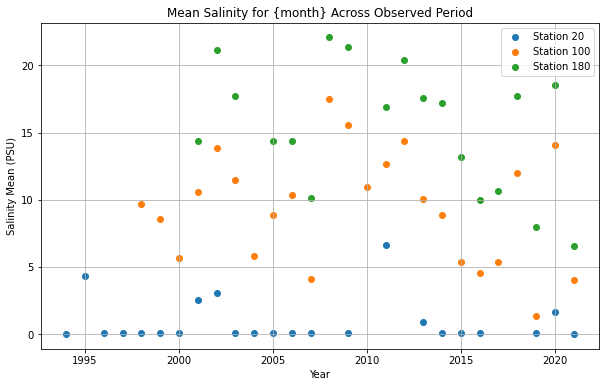

In [71]:
##################################### Plot means of one month for all years ###########################################33
'''

month_data = []
i = 1

# Extract January mean salinity for each station for every year
for stat in S_stats_mo:
    for station, data in stat.items():
        monthly_mean = data.loc[(data.index.get_level_values('Month') == i), 'mean']
        month_data.append((station, monthly_mean))

# Plotting time series for mean salinity for every January of every year
plt.figure(figsize=(10, 6))
for station, monthly_mean in month_data:
    plt.scatter(monthly_mean.index.get_level_values('Year').values, monthly_mean.values, label=f'Station {station}')

plt.title('Mean Salinity for {month} Across Observed Period')
plt.xlabel('Year')
plt.ylabel('Salinity Mean (PSU)')
plt.legend()
plt.grid(True)

'''